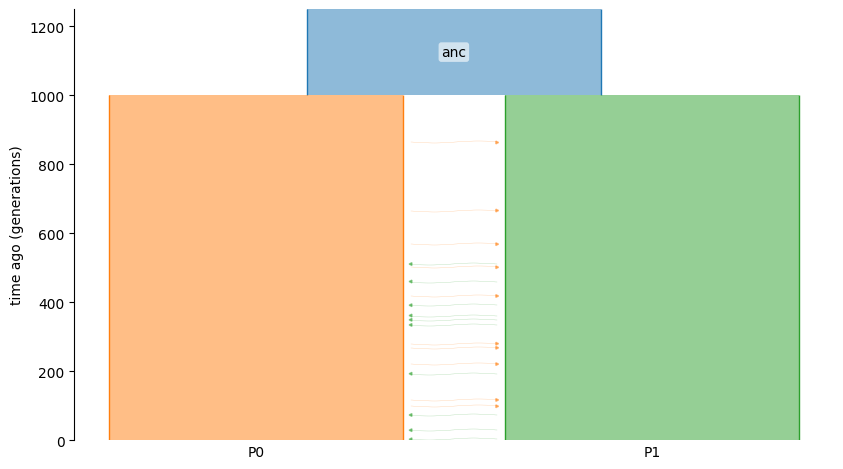

In [5]:
import msprime as msp
import demes
import demesdraw

q_anc = 1e4
q0 = 1e4
q1 = 1e4
m = 0.0001
tau = 1000
demo = msp.Demography()
demo.add_population(initial_size= q_anc, name = "anc")
demo.add_population(initial_size = q0, name = "P0")
demo.add_population(initial_size = q1, name = "P1")
demo.set_symmetric_migration_rate(populations=("P0", "P1"), rate= m)
tmp = [f"P{i}" for i in range(2)]
demo.add_population_split(time = tau, derived=tmp, ancestral="anc")
g = demo.to_demes()
demesdraw.tubes(g)
# print(g)
sample_size = 10
samples = {f"P{i}": sample_size for i in range(2)}
anc = msp.sim_ancestry(samples=samples, demography=demo, recombination_rate=1e-8, sequence_length=1e7, random_seed=42)
ts = msp.sim_mutations(anc, rate=1e-8, random_seed=42)

import jax.random as jr
import numpy as np
import random
key = jr.PRNGKey(0)

In [6]:
import jax.numpy as jnp

key, subkey = jr.split(key)

num_pop = 2
sample_config = {f"P{i}": 0 for i in range(num_pop)}
# BECAUSE I DON'T SPLIT SUBKEY THE SAMPLE CHOSEN IS FIXED
samples = jr.choice(subkey, ts.num_samples, shape=(2,), replace=False)
sample1, sample2 = samples.item(0), samples.item(1)

# Please note that the ancestral population by default is population 0
# and any subpopulation increments by 1
pop1 = ts.node(sample1).population - 1
pop2 = ts.node(sample2).population - 1
sample_config[f"P{pop1}"] += 1
sample_config[f"P{pop2}"] += 1
init_vertices = jnp.array([pop1, pop2])

print(init_vertices)
print(sample_config)
print(sample1)
print(sample2)

tmrca_spans = []
current_tmrca = None
current_span_length = 0

for tree in ts.trees():
    span_length = tree.interval.right - tree.interval.left
    
    # Get TMRCA for this pair in current tree
    tmrca = tree.tmrca(sample1, sample2) # tree.tmrca(sample1, sample2) / (4 * Ne)
    
    if current_tmrca is None:
        # First span
        current_tmrca = tmrca
        current_span_length = span_length
    elif tmrca == current_tmrca:
        # Continue current span
        current_span_length += span_length
    else:
        # New span, record the previous one
        tmrca_spans.append(jnp.array([current_tmrca, current_span_length]))
        current_tmrca = tmrca
        current_span_length = span_length
    
# Add the last span
if current_tmrca is not None:
    tmrca_spans.append(jnp.array([current_tmrca, current_span_length]))

tmrca_spans = jnp.array(tmrca_spans)
print(tmrca_spans)

[1 0]
{'P0': 1, 'P1': 1}
22
0
[[ 8281.69558997  1636.        ]
 [28065.11541213   795.        ]
 [22269.2535078   4617.        ]
 ...
 [10628.08249648  1986.        ]
 [16118.07926117  9220.        ]
 [18250.50803671    31.        ]]


In [7]:
from momi3.momi import Momi3
momi_object = Momi3(g).iicr(2)
# params = [("demes", 0, "epochs", 0, "start_size"), ("demes", 1, "epochs", 0, "start_size")]
params = [("demes", 0, "epochs", 0, "start_size")]
f, x = momi_object.reparameterize(list(params))
print(x)

# a toy example just to run the likelihood once
parameters = list(x.keys())
x[parameters[0]] = np.array(8000.0)
params = x
# We use unique_coalescence_times because we are using every possible unique coalescence time 
# between two sampling configuration
# t = jnp.linspace(1e-4, 100000, 1000)
# c = likelihood(params, t, sample_config)

import jax
import jax.numpy as jnp
import phlash
from phlash.likelihood.arg import log_density

def call_momi(t_value, num_samples, x):
    """Computes c and p from momi_object."""
    c, p = momi_object(t=t_value, num_samples=num_samples, params=f(x))
    return c, p

# Vectorizing over t
batched_call_momi = jax.vmap(call_momi, in_axes=(0, None, None))

def likelihood(x, tmrca_spans, num_samples):
    """Computes the negative log-likelihood (for minimization)."""
    t = jnp.linspace(1e-4, 100000, 1000)
    c_values, log_p_values = batched_call_momi(t, num_samples, x)
    eta = phlash.size_history.SizeHistory(t=t, c=c_values)
    dm = phlash.size_history.DemographicModel(
        eta=eta, theta=None, rho=1e-8
    )
    # return -(jnp.sum(jnp.log(c_values) + log_p_values))  # Negative for minimization
    return log_density(dm, tmrca_spans[None])


{frozenset({('demes', 0, 'epochs', 0, 'end_size'), ('demes', 0, 'epochs', 0, 'start_size')}): Array(10000., dtype=float64)}


{'P0': 1, 'P1': 1}


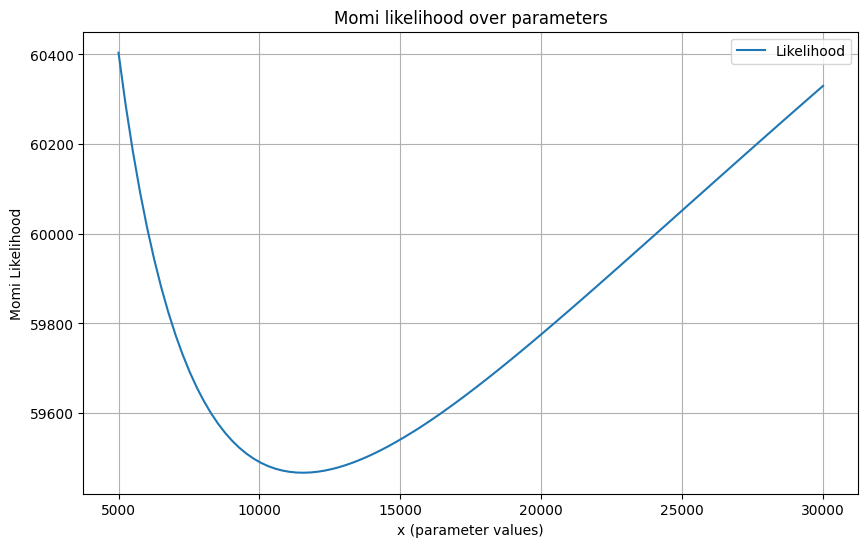

In [8]:
from jax import vmap
x_values = jnp.linspace(5000, 30000, 100)  # adjust these steps as needed

# Vectorize the likelihood computation over x_values
def compute_likelihood(val):
    updated_x = x.copy()
    updated_x[parameters[0]] = val
    params = updated_x
    return -likelihood(params, tmrca_spans, sample_config)

# Use vmap to compute likelihoods for all x_values
likelihoods = vmap(compute_likelihood)(x_values)

print(sample_config)
import matplotlib.pyplot as plt
# Plot
plt.figure(figsize=(10, 6))
plt.plot(x_values, likelihoods, label='Likelihood')
plt.xlabel('x (parameter values)')
plt.ylabel('Momi Likelihood')
plt.title('Momi likelihood over parameters')
plt.legend()
plt.grid(True)
plt.show()